In [21]:
import numpy as np
from utils import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import t
import plotly.graph_objects as go


pso = PSOOptim(n_iters=100, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=False)
optim = DEOptim(maxiter=100, visualize=False)

In [22]:
noise_scales = [1, 5, 10, 30, 50, 70]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
n_train_data_points = 70
n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5


num_iter = 20
df_results = pd.DataFrame({ "noise scale":[], "Log Likelihood PSO":[], "Log Likelihood RS":[], "Log Likelihood DE":[]})
for noise in tqdm(noise_scales):
    for i in range(0,num_iter):
        X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func, noise_scale=noise)

        rs = RandomOptim(maxiter=1000, visualize=False, random_state=i)

        X_train, y_train = generate_sample(n_train_data_points, n_dims, lower_bound, upper_bound, target_func, noise_scale=noise)
        # pso
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])

        # rs
        gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_rs.fit(X.T, y[...,None])

        # de
        gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_de.fit(X.T, y[...,None])

        df_results.loc[len(df_results)] = [noise, gpr_pso.log_marginal_likelihood_value_, gpr_rs.log_marginal_likelihood_value_, gpr_de.log_marginal_likelihood_value_]

print(df_results)

100%|██████████| 6/6 [03:57<00:00, 39.57s/it]

     noise scale  Log Likelihood PSO  Log Likelihood RS  Log Likelihood DE
0            1.0       -34612.303479      -43460.232650      -34611.012889
1            1.0       -34611.078513      -34837.489700      -34611.012889
2            1.0       -34611.035903      -37487.054003      -34611.012889
3            1.0       -34611.083412      -37802.859931      -34611.012889
4            1.0       -34611.015379      -42079.251748      -34611.012889
..           ...                 ...                ...                ...
115         70.0      -261263.091202     -261647.328102     -266727.762602
116         70.0      -261262.749010     -261942.623563     -261262.743709
117         70.0      -267159.434374     -261503.320745     -261262.743711
118         70.0      -261262.751678     -261669.120809     -266727.762602
119         70.0      -261262.786525     -261928.487530     -263262.551375

[120 rows x 4 columns]


In [23]:
df_results_ = df_results.groupby(['noise scale'], as_index=False).agg({'Log Likelihood PSO':['mean','std'], 'Log Likelihood RS':['mean','std'], 'Log Likelihood DE':['mean','std']})

df_results_["conf_95_o_pso"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood PSO"]["std"] + df_results_["Log Likelihood PSO"]["mean"]
df_results_["conf_95_u_pso"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood PSO"]["std"] + df_results_["Log Likelihood PSO"]["mean"]

df_results_["conf_95_o_rs"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood RS"]["std"] + df_results_["Log Likelihood RS"]["mean"]
df_results_["conf_95_u_rs"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood RS"]["std"] + df_results_["Log Likelihood RS"]["mean"]

df_results_["conf_95_o_de"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood DE"]["std"] + df_results_["Log Likelihood DE"]["mean"]
df_results_["conf_95_u_de"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood DE"]["std"] + df_results_["Log Likelihood DE"]["mean"]

In [24]:
def rotate_func(x):
    return df_results_["Log Likelihood PSO"]["mean"]#-3_500 * x - 17_000

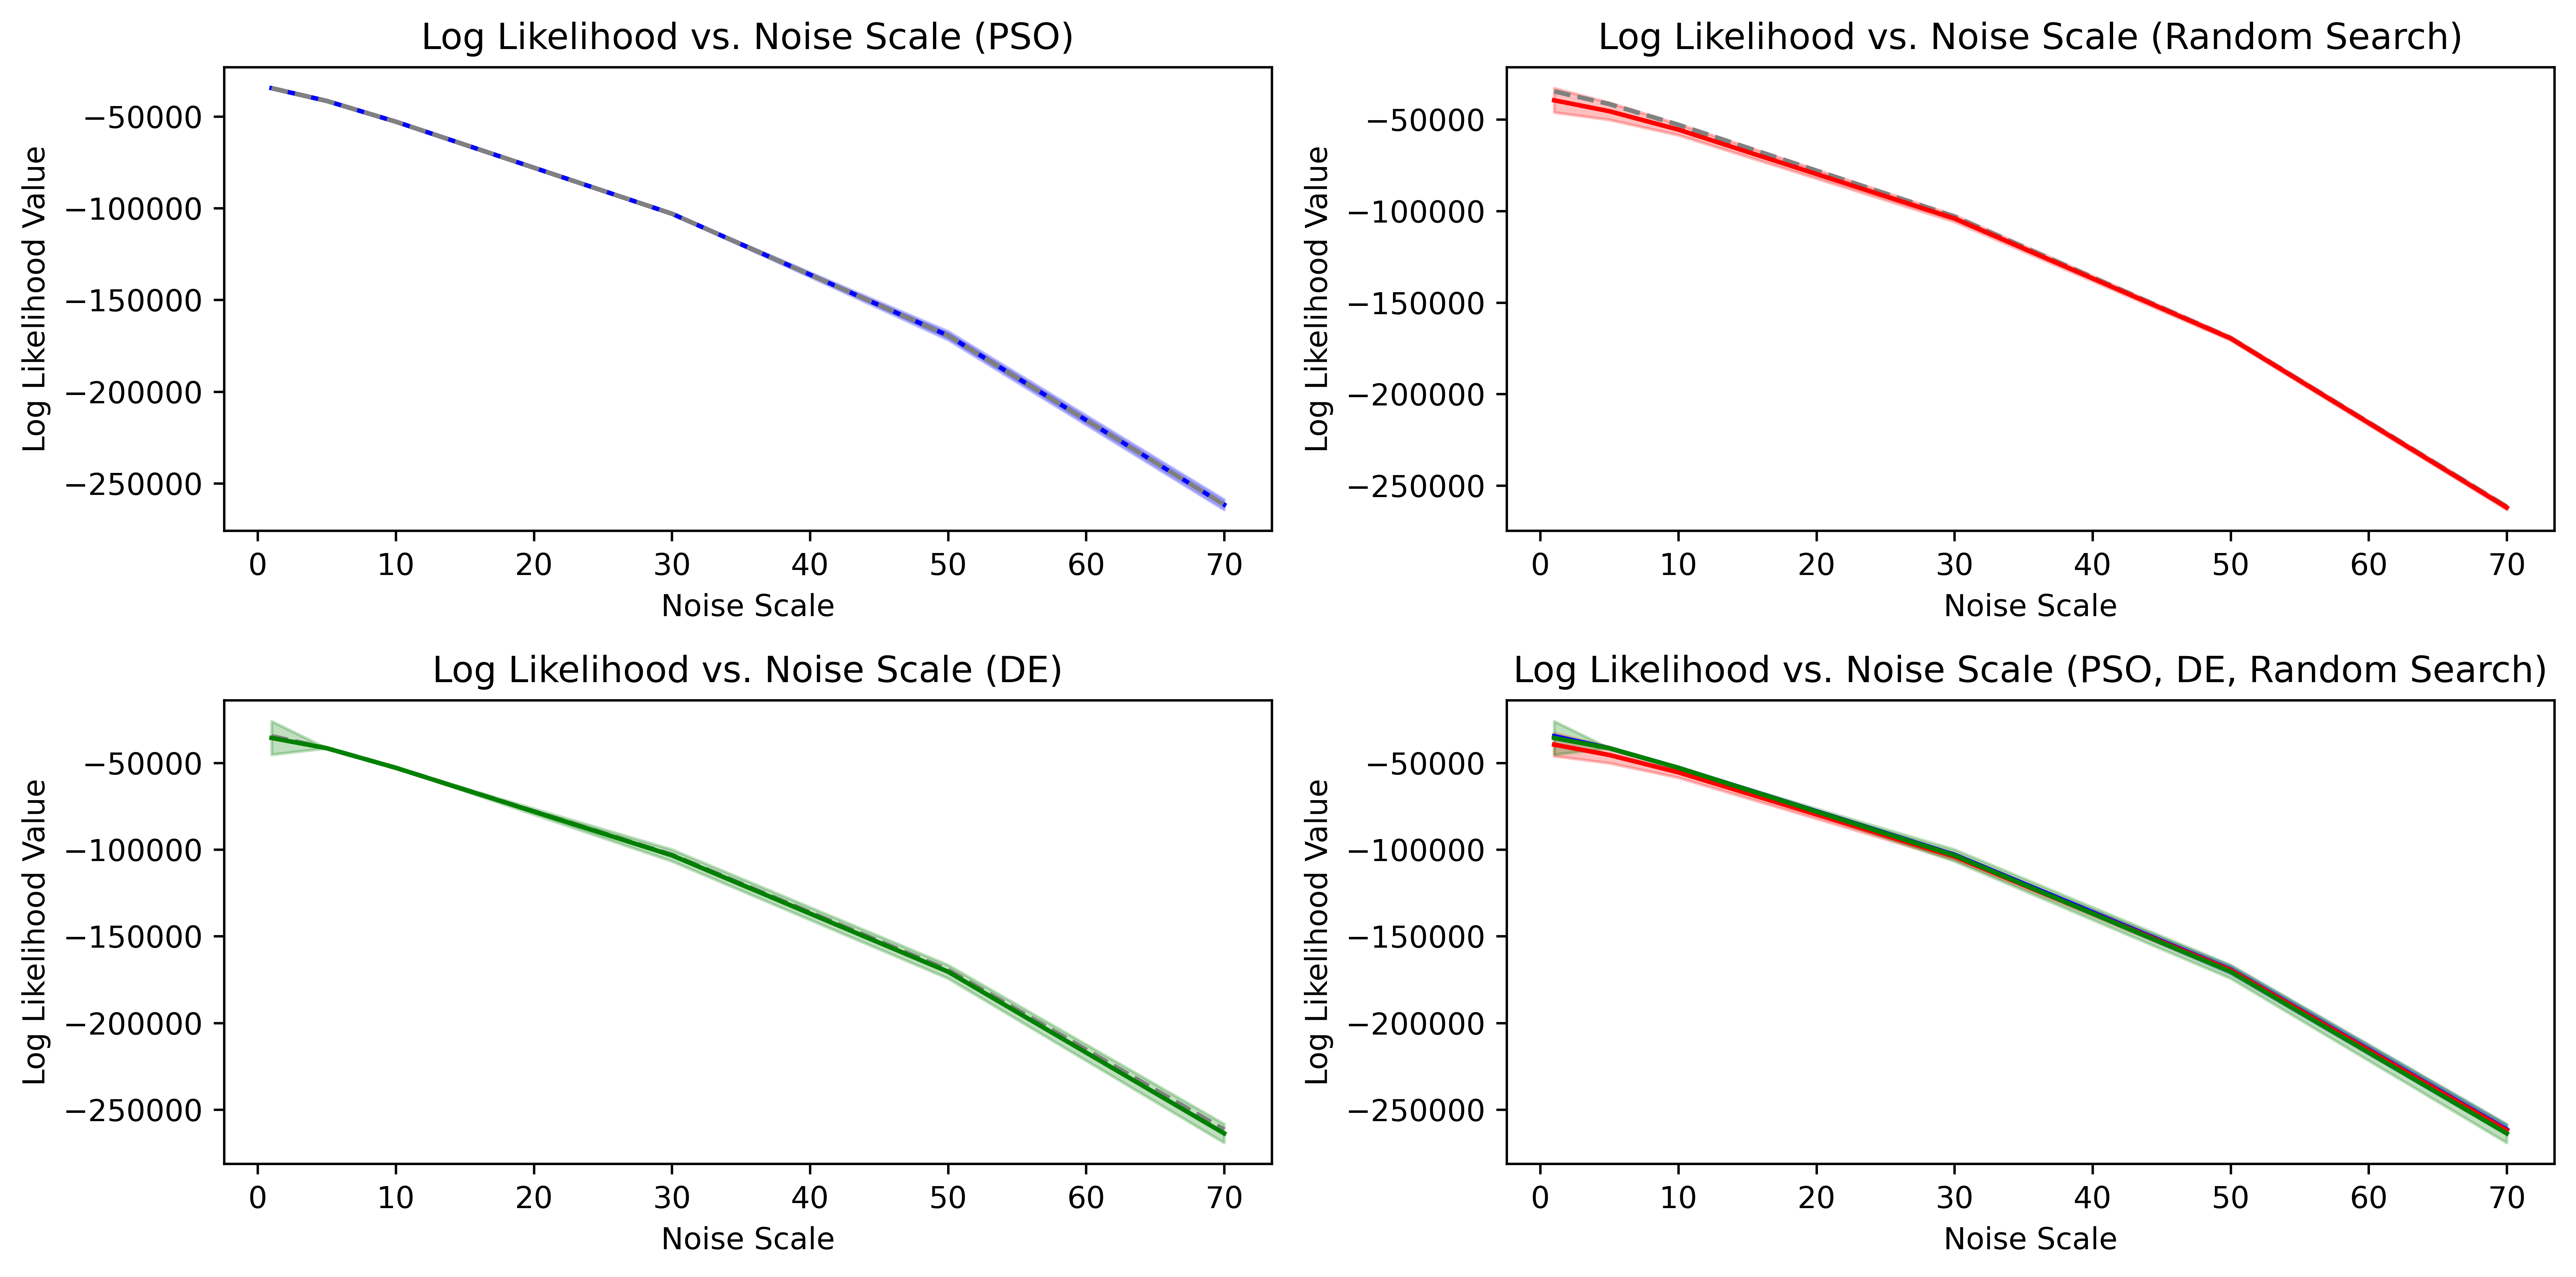

In [25]:
plt.figure(figsize=(12,6), dpi=600)
plt.subplot(221)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
# plot rotate_func with pointed lines
Xs = df_results_["noise scale"]
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (PSO)")
plt.subplot(222)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (Random Search)")
plt.tight_layout()

plt.subplot(223)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (DE)")
plt.subplot(224)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.tight_layout()

In [26]:
df_results_

noise scale Log Likelihood PSO              Log Likelihood RS               \
                            mean          std              mean          std   
0         1.0      -34611.428341     0.746292     -39491.904269  3159.173751   
1         5.0      -41573.710674     1.372834     -45488.119103  2230.236344   
2        10.0      -52869.898796     0.694609     -55517.296108  1445.038355   
3        30.0     -103030.114100    39.897011    -104067.741978   872.368653   
4        50.0     -169399.197340  1101.629554    -169598.235968   496.007834   
5        70.0     -261559.008488  1318.210526    -262016.366912   559.740326   

  Log Likelihood DE                conf_95_o_pso  conf_95_u_pso  \
               mean           std                                 
0     -35638.299231  4.593954e+03  -34609.866333  -34612.990349   
1     -41573.227726  3.211801e-01  -41570.837300  -41576.584047   
2     -52869.603887  4.583209e-08  -52868.444963  -52871.352628   
3    -103381.756497  1.611165e+03 -102946.608695 -103113.619504   
4    -170470.363034  1.846381e+03 -167093.460185 -171704.934496   
5    -263748.722416  2.588714e+03 -258799.962148 -264318.054828   

    conf_95_o_rs   conf_95_u_rs   conf_95_o_de   conf_95_u_de  
                                                               
0  -32879.677616  -46104.130922  -26023.042887  -45253.555576  
1  -40820.180788  -50156.057418  -41572.555488  -41573.899963  
2  -52492.796073  -58541.796144  -52869.603887  -52869.603887  
3 -102241.853403 -105893.630553 -100009.550409 -106753.962584  
4 -168560.079640 -170636.392295 -166605.842205 -174334.883863  
5 -260844.816946 -263187.916878 -258330.482209 -269166.962623

In [27]:
Xs = df_results_["noise scale"].to_numpy()
Ys = {
    "PSO": df_results_["Log Likelihood PSO"]["mean"].to_numpy(),
    "RS": df_results_["Log Likelihood RS"]["mean"].to_numpy(),
    "DE": df_results_["Log Likelihood DE"]["mean"].to_numpy()
}
confidence_intervalls = {
    "PSO": (df_results_["conf_95_o_pso"].to_numpy(), df_results_["conf_95_u_pso"].to_numpy()),
    "RS": (df_results_["conf_95_o_rs"].to_numpy(), df_results_["conf_95_u_rs"].to_numpy()),
    "DE": (df_results_["conf_95_o_de"].to_numpy(), df_results_["conf_95_u_de"].to_numpy())
}

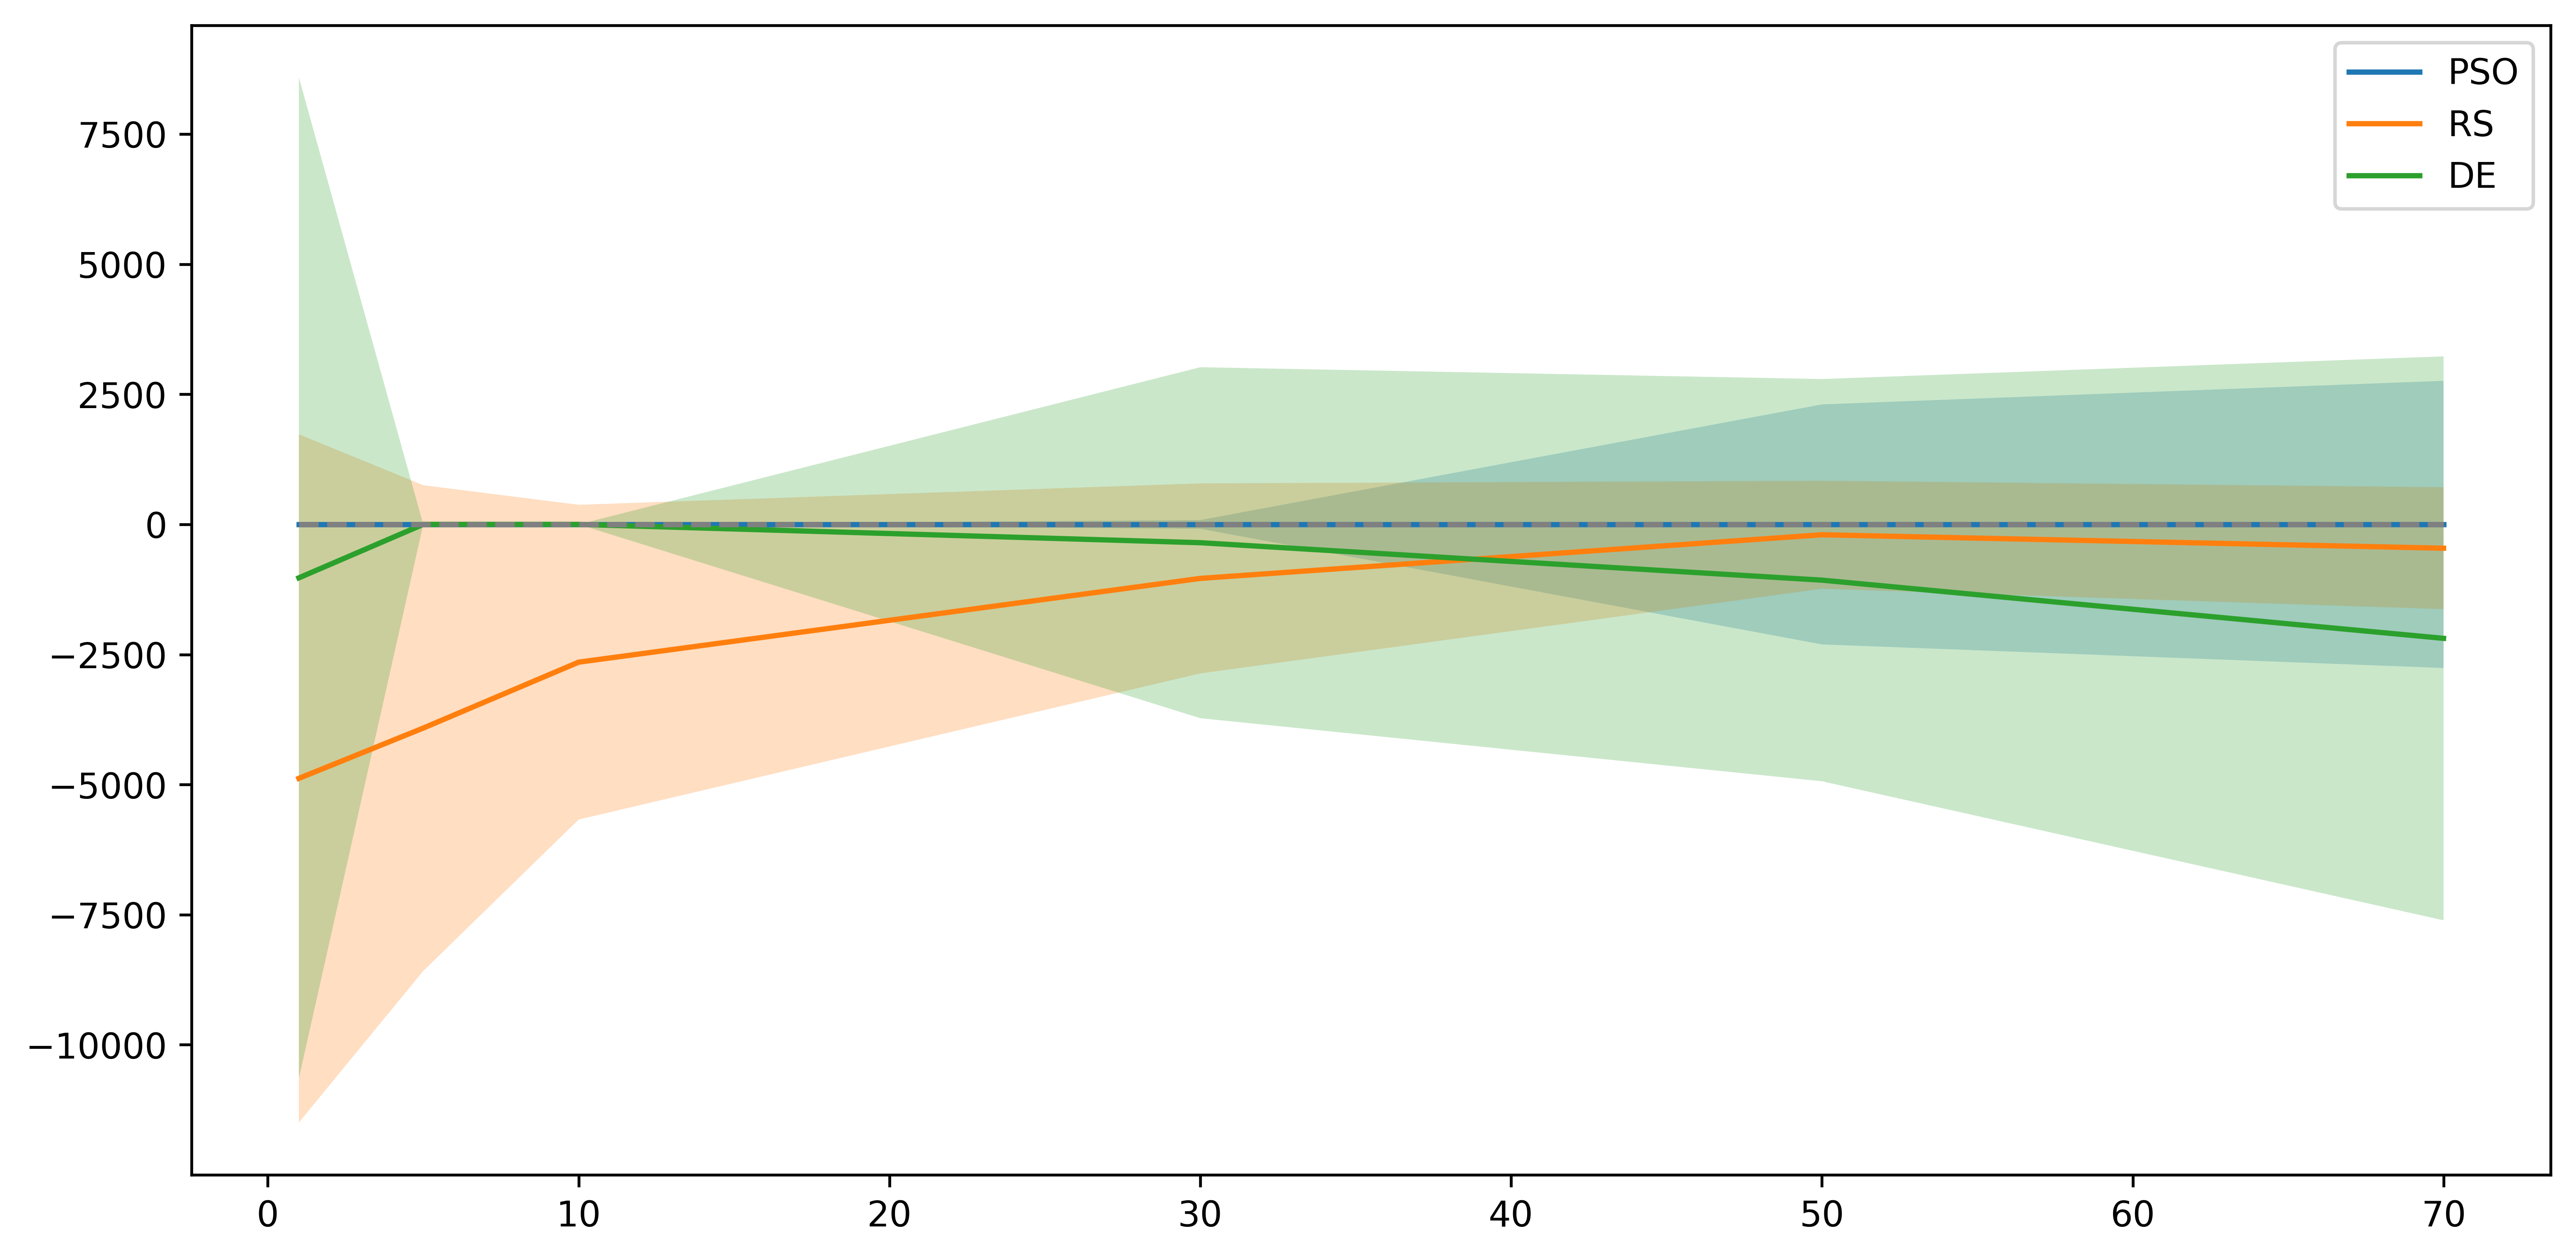

In [28]:
plt.figure(figsize=(12,6), dpi=600)
for y in Ys: # for each y-value
    plt.plot(Xs, Ys[y]-rotate_func(Xs), label=y)
    plt.fill_between(Xs, confidence_intervalls[y][0]-rotate_func(Xs), confidence_intervalls[y][1]-rotate_func(Xs), alpha=.25)

plt.plot(Xs, np.zeros(len(Xs)), color="grey", linestyle="--")
plt.legend();

In [30]:
rotation = rotate_func(df_results_["noise scale"])

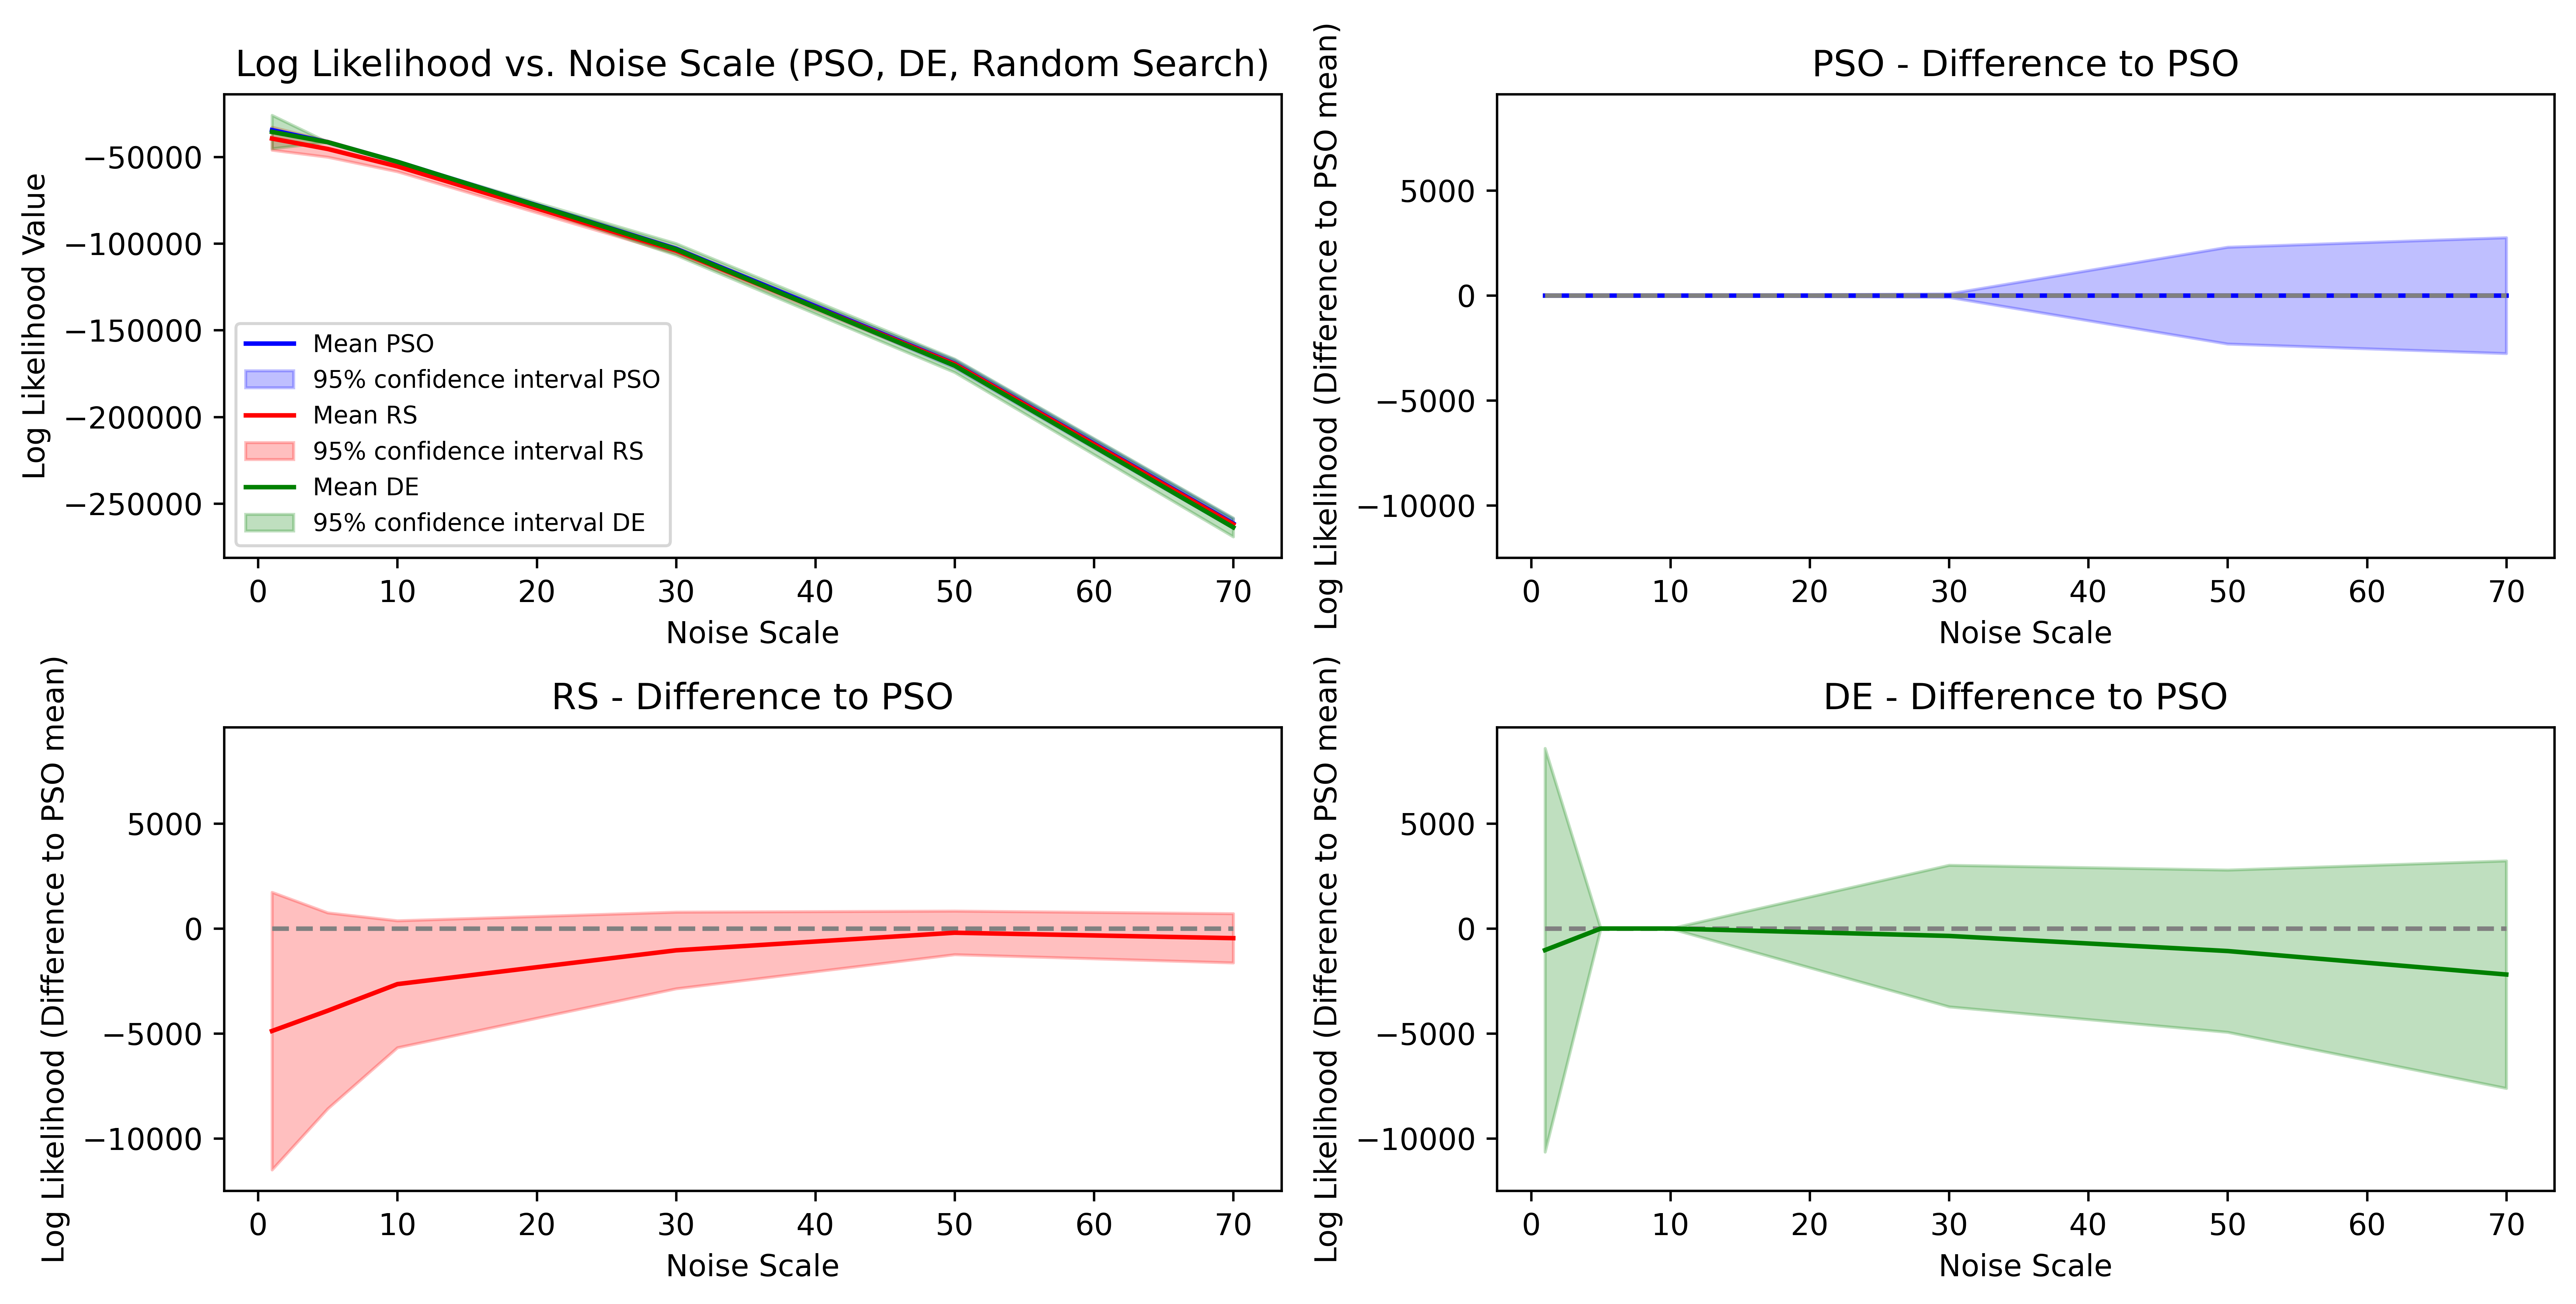

In [43]:
fig = plt.figure(figsize=(12,6), dpi=600)

plt.subplot(221)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b", label="Mean PSO")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25, label="95% confidence interval PSO")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r", label="Mean RS")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25, label="95% confidence interval RS")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g", label="Mean DE")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25, label="95% confidence interval DE")
plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.legend(fontsize=8)

ax = fig.add_subplot(222)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"]-rotation, color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"]-rotation, df_results_["conf_95_o_pso"]-rotation, color="b", alpha=.25)
plt.plot(Xs, np.zeros_like(Xs), color="grey", linestyle="--")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood (Difference to PSO mean)")
plt.title("PSO - Difference to PSO")

plt.subplot(223, sharey=ax)
plt.plot(Xs, np.zeros_like(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"]-rotation, color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"]-rotation, df_results_["conf_95_o_rs"]-rotation, color="r", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood (Difference to PSO mean)")
plt.title("RS - Difference to PSO")

plt.subplot(224, sharey=ax)
plt.plot(Xs, np.zeros_like(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"]-rotation, color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"]-rotation, df_results_["conf_95_o_de"]-rotation, color="g", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood (Difference to PSO mean)")
plt.title("DE - Difference to PSO")

plt.tight_layout()
plt.show()
